In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries

In [3]:
import cv2
import torch
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torchvision
import shutil
import imageio
from IPython import display
from PIL import Image
from glob import glob
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load Data

In [5]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

In [6]:
data = torchvision.datasets.MNIST(root='../data/mnist', train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17065530.62it/s]


Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 456703.93it/s]


Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4249826.49it/s]


Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2324936.39it/s]

Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw



In [7]:
batch_size = 100
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [8]:
z_dim = 100
image_dim = 32 * 32
num_classes = 10

# Visualization

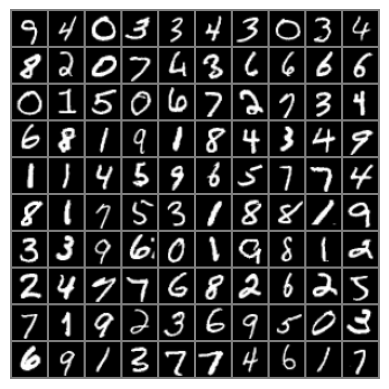

In [9]:
data_iter = iter(dataloader)
images, _ = next(data_iter)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg[0], cmap='gray')
    plt.axis('off')
    plt.show()

imshow(torchvision.utils.make_grid(images, nrow=10))

# Network Initialization

In [10]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# Generator

In [11]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()

        self.z_dim = z_dim
        
        self.model = nn.Sequential(
            nn.Linear(z_dim, 128 * (8) ** 2),
            nn.BatchNorm1d(128 * (8) ** 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise):
        image = self.model(noise)
        return image

In [38]:
generator = Generator(z_dim=z_dim)
generator.to(device)
generator.apply(weights_init_normal)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Unflatten(dim=1, unflattened_size=(128, 8, 8))
    (4): Upsample(scale_factor=2.0, mode='nearest')
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Upsample(scale_factor=2.0, mode='nearest')
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Tanh()
  )
)

# Discriminator

In [39]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            nn.Flatten(),

            nn.Linear(128 * 2 ** 2, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

In [40]:
discriminator = Discriminator()
discriminator.to(device)
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout2d(p=0.25, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout2d(p=0.25, inplace=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout2d(p=0.25, inplace=False)
    (15): Flatt

# Train

In [41]:
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [42]:
lambda_gp = 10
adversarial_loss = nn.BCELoss()

In [43]:
n_epochs = 50

In [44]:
d_loss_s = []
g_loss_s = []

In [45]:
os.makedirs("./dragan", exist_ok=True)

In [46]:
def compute_gradient_penalty(D, X, lambda_gp=10.0):
    alpha = torch.rand_like(X)
    interpolates = alpha * X + (1 - alpha) * (X + 0.5 * X.std() * torch.rand_like(X))
    interpolates.requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size(), device=X.device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients_norm = gradients.norm(2, dim=1)
    gradient_penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty

In [48]:
for epoch in range(n_epochs):
    for batch_idx, (images, _) in enumerate(dataloader):

        valid = torch.ones((images.shape[0], 1), device=device) * (0.9 + 0.1 * torch.rand(images.shape[0], 1, device=device))
        fake = torch.zeros((images.shape[0], 1), device=device) * (0.1 * torch.rand(images.shape[0], 1, device=device))


        real_images = images.to(device)

        generator_optimizer.zero_grad()

        z = torch.randn((images.shape[0], z_dim), device=device)

        generated_images = generator(z)

        g_loss = adversarial_loss(discriminator(generated_images), valid)

        g_loss.backward()
        generator_optimizer.step()

        discriminator_optimizer.zero_grad()

        real_loss = adversarial_loss(discriminator(real_images), valid)
        fake_loss = adversarial_loss(discriminator(generated_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        gradient_penalty = compute_gradient_penalty(discriminator, real_images)
        gradient_penalty.backward()

        discriminator_optimizer.step()

        if batch_idx % 600 == 0:
            g_loss_s.append(g_loss.item())
            d_loss_s.append(d_loss.item())
            
            print(f"[Epoch {epoch}/{n_epochs}] [Batch {batch_idx}/{len(dataloader)}] [D loss: {d_loss:.6f}] [G loss: {g_loss:.6f}]")

            save_image(generated_images.data, f"./dragan/epoch_{epoch+1}.png", nrow=10, normalize=True)

[Epoch 0/50] [Batch 0/600] [D loss: 0.693580] [G loss: 0.685660]
[Epoch 1/50] [Batch 0/600] [D loss: 1.902348] [G loss: 0.209280]
[Epoch 2/50] [Batch 0/600] [D loss: 1.998015] [G loss: 0.212639]
[Epoch 3/50] [Batch 0/600] [D loss: 2.097848] [G loss: 0.215491]
[Epoch 4/50] [Batch 0/600] [D loss: 2.133527] [G loss: 0.199776]
[Epoch 5/50] [Batch 0/600] [D loss: 1.985130] [G loss: 0.190432]
[Epoch 6/50] [Batch 0/600] [D loss: 1.887460] [G loss: 0.208408]
[Epoch 7/50] [Batch 0/600] [D loss: 1.848230] [G loss: 0.218055]
[Epoch 8/50] [Batch 0/600] [D loss: 2.076437] [G loss: 0.227083]
[Epoch 9/50] [Batch 0/600] [D loss: 2.158321] [G loss: 0.215844]
[Epoch 10/50] [Batch 0/600] [D loss: 1.991689] [G loss: 0.197428]
[Epoch 11/50] [Batch 0/600] [D loss: 2.668101] [G loss: 0.217568]
[Epoch 12/50] [Batch 0/600] [D loss: 2.531683] [G loss: 0.221898]
[Epoch 13/50] [Batch 0/600] [D loss: 4.015375] [G loss: 0.212453]
[Epoch 14/50] [Batch 0/600] [D loss: 3.354583] [G loss: 0.230837]
[Epoch 15/50] [Batch

# Results

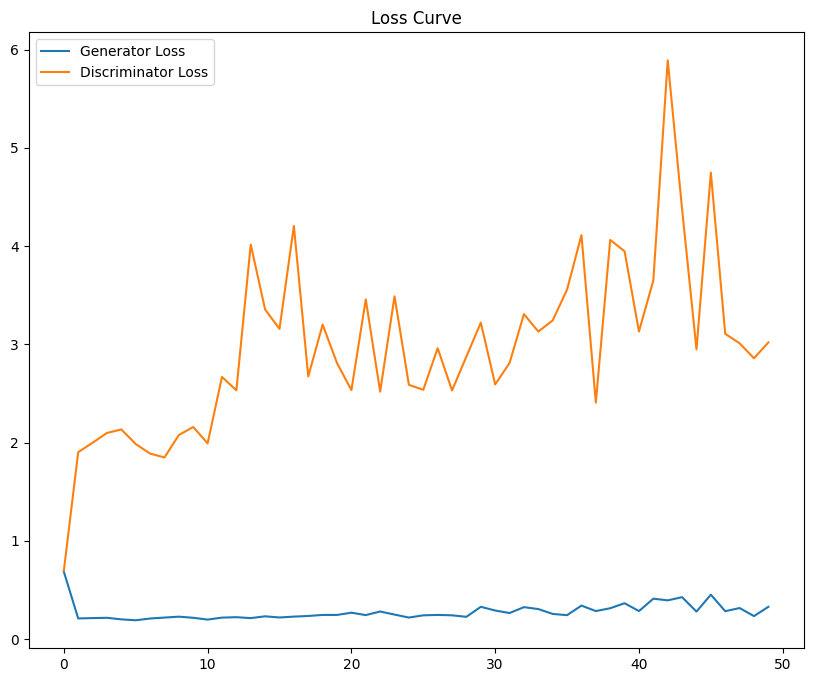

In [49]:
plt.figure(figsize=(10, 8))
plt.plot(g_loss_s)
plt.plot(d_loss_s)
plt.title("Loss Curve")
plt.legend(["Generator Loss", "Discriminator Loss"])
plt.show()

# GIF

In [50]:
files = glob("./dragan/*.png")
gif_file = "./dragan/mnist_dragan.gif"

In [51]:
with imageio.get_writer(gif_file, mode='I') as writer:
    for file in files:
        image = imageio.v2.imread(file)
        writer.append_data(image)

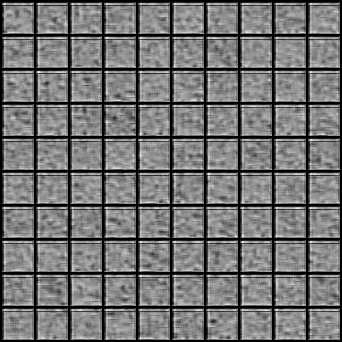

In [52]:
display.Image(gif_file)